In [1]:
#uses isochrones (MIST isochrones package) -- see installation instructions at https://isochrones.readthedocs.io/en/latest/
#For easy installation of isochrone files and bolometric corrections, within isochrones environment also install minimint -- see instructions https://github.com/segasai/minimint
#on first import of minimint, run minimint.download_and_prepare(filters=["UBVRIplus","WFIRST","JWST","HST_ACSWF"])
#including in 'filters' any other desired filter sets listed at MIST website: https://waps.cfa.harvard.edu/MIST/model_grids.html
#By default this saves isochrone files to the site-packages folder of minimint.  
#Check the relevant folder of isochrones (e.g., if isochrones is installed within an isochrones environment, anaconda3/envs/isochrones/lib/python3.12/site-packages/isochrones/mist/) 
#to make sure all desired filter sets and filters are listed in the file bc.py.  For example, this file by default does not include HST or WFIRST filters.
#If using WFIRST filters, add the following line (e.g., under the existing line in bc.py
#GALEX=["GALEX_FUV", "GALEX_NUV"],
#add
#WFIRST=["R062","Z087","Y106","J129","W146","H158","F184"],
#Another example, if using HST ACS/WFC filters F606W and F814, add
#HST_ACSWF=["ACS_WFC_F606W","ACS_WFC_F814W"],

import xymass
import numpy as np
import minimint
import astropy
import matplotlib.pyplot as plt
import astropy.units as u
import scipy
from isochrones.mist import MIST_Isochrone
from isochrones.mist import MIST_EvolutionTrack
from isochrones.mist.bc import MISTBolometricCorrectionGrid
from isochrones.mist import MISTEvolutionTrackGrid, MISTIsochroneGrid

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


In [2]:
logage=np.log10(1.e+9) # log10(age/year) of stellar population
feh=-2. #[Fe/H] metallicity of stellar population
distance=100000.*u.pc #distance to stellar population
dmodulus=5.*np.log10(distance.to(u.pc).value)-5.
resolution_limit=0.5*u.arcsec #instrument angular resolution limit
resolution_limit_physical=resolution_limit.to(u.radian).value*distance

In [3]:
mm=minimint.Interpolator(['Gaia_G_EDR3']) #filter doesn't matter here, just needed to pick one to create minimint object
m_max=mm.getMaxMass(logage,feh) #maximum mass, in M_sun, for adopted age, metallicity

In [4]:
n_object=10000 #sample size

sb_model='plum' #specify surface brightness model ('plum', 'exp', '2bg', 'uni')
r_scale=100.*u.pc #specify scale radius
ellipticity=0.5 #specify ellipticity for flattened (elliptical) system, e=1-b/a
position_angle=55. #specify position angle for flattened system

#generate sample of stellar positions according to parameters above
r2d=xymass.sample_r2d(size=n_object,model=sb_model,r_scale=r_scale,ellipticity=ellipticity,position_angle=position_angle) 

In [5]:
m_min=0.1 #specify minimum stellar mass in M_sun
imf_model='kroupa' #specify IMF model ('kroupa', 'salpeter', 'BPL', 'lognormal')
imf_m_min=0.1 #specify minimum stellar mass in M_sun
mass_primary=xymass.sample_imf(size=n_object,model=imf_model,m_min=m_min,m_max=m_max).mass*u.M_sun


In [15]:
f_binary=0.5 #specify binary fraction.  Expected number of stars will become n_object*(1+f_binary).  
#Actual number will be Poisson distributed

#randomly (according to f_binary) select objects from r2d to be replaced by two components comprising binary system
#sample positions of binary companions from physically-calculated orbits according to binary_model.  
#Note that m_min need not be the same value used to sample primary masses above (if, for example, sample of primaries is mass-limited and secondaries are not)
r2d_with_binaries_raghavan=xymass.add_binaries_physical(r2d.r_xyz,mass_primary,f_binary=f_binary,\
                                               m_min=m_min,binary_model='Raghavan2010')

mass_secondary=xymass.sample_imf(size=n_object,model='kroupa',m_min=m_min,m_max=m_max).mass*u.M_sun 
r2d_with_binaries_bpl=xymass.add_binaries_func(r2d.r_xyz,\
                                               separation_func='bpl',mass_primary=mass_primary,\
                                               f_binary=f_binary,mass_secondary=mass_secondary,s_min=1.*u.AU,\
                                               s_max=100000.*u.AU,s_break=100.*u.AU,alpha1=1.01,\
                                               alpha2=2.,projected=True)

#The '.item' key distinguishes singles, primaries and secondaries.
singles_raghavan=np.where(r2d_with_binaries_raghavan.item==0)[0] #single objects
primaries_raghavan=np.where(r2d_with_binaries_raghavan.item==1)[0] #primaries within binary objects
secondaries_raghavan=np.where(r2d_with_binaries_raghavan.item==2)[0] #secondaries within binary objects

In [16]:
#need to make sure these filters are in bc.py file in site-packages
filter_names=['G','BP','RP','DECam_g','DECam_r','DECam_i','DECam_z','DECam_Y','SDSS_u','SDSS_g','SDSS_r','SDSS_i','SDSS_z','PS_g','PS_r','PS_i','PS_z','V','F090W','F150W','ACS_WFC_F606W','ACS_WFC_F814W','LSST_u','LSST_g','LSST_r','LSST_i','LSST_z','LSST_y','R062','Z087','Y106','J129','W146','H158','F184']

mist_track=MIST_EvolutionTrack()
bc_grid=MISTBolometricCorrectionGrid(filter_names)

In [17]:
#interpolate isochrone at each mass
iso=mist_track.generate(r2d_with_binaries_raghavan.mass,logage,feh,accurate=True)
#get bolometric correction for all filters in filter_names
iso_bc=bc_grid.interp([iso['Teff'],iso['logg'],iso['feh'],np.zeros(len(iso))],filter_names)
#apply bolometric corrections
iso_filter_mag=(np.array(iso['Mbol'])-iso_bc.T).T

In [18]:
Mbol_sun=4.74 #solar absolute bolometric magnitude
r2d_with_binaries_blend_raghavan=xymass.binary_blend(r2d_with_binaries_raghavan,iso_filter_mag,Mbol_sun,resolution_limit_physical)

In [19]:
L_V=10.**(-(iso_filter_mag[17]-Mbol_sun)/2.5) #solar V-band luminosity
M_V=Mbol_sun-2.5*np.log10(np.sum(L_V)) #V-band luminosity of sample population
mass_tot=np.sum(r2d_with_binaries_raghavan.mass) #total mass of sampled population

f090w=r2d_with_binaries_blend_raghavan.mag.T[18]+dmodulus #apparent magnitude of sampled stars in JWST F090W
f150w=r2d_with_binaries_blend_raghavan.mag.T[19]+dmodulus #apparent magnitude of sampled stars in JWST F150W

#simulate observational errors similar to JWST ERS program (Weisz et al. 2022)
e_f090w=10.**(0.3*f090w-9.7)
e_f150w=10.**(0.3*f150w-9.35)

f090w_obs=f090w+np.random.normal(loc=0.,scale=e_f090w)
f150w_obs=f150w+np.random.normal(loc=0.,scale=e_f150w)

mag=f090w_obs #simulated F090W magnitudes, including observational errors
col=f090w_obs-f150w_obs #simulated F090W - F150W colors, including observational errors

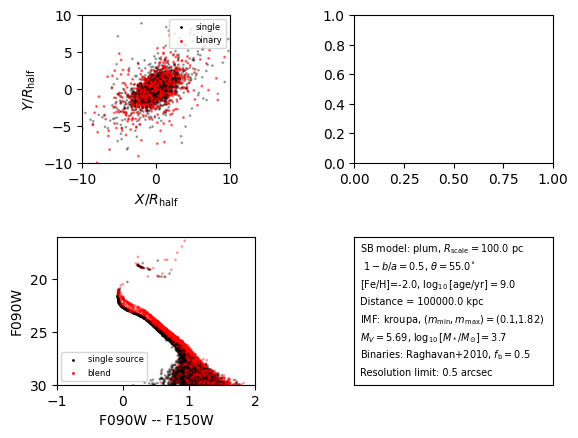

In [20]:
fig=plt.figure(1)
ax1=fig.add_subplot(221)
ax2=fig.add_subplot(222)
ax3=fig.add_subplot(223)
ax4=fig.add_subplot(224)
fig.subplots_adjust(wspace=0.5,hspace=0.5)

cols=np.full(len(r2d_with_binaries_raghavan.item),'k')
cols[r2d_with_binaries_raghavan.item>0]='r'
ax1.scatter([-999],[-999],color='k',label='single',s=1)
ax1.scatter([-999],[-999],color='r',label='binary',s=1)
ax1.scatter(r2d_with_binaries_raghavan.r_xyz.T[0]/r2d.rhalf_2d.value,r2d_with_binaries_raghavan.r_xyz.T[1]/r2d.rhalf_2d.value,color=cols,s=1,alpha=0.3)
ax1.set_xlabel(r'$X / R_{\rm half}$')
ax1.set_ylabel(r'$Y / R_{\rm half}$')
ax1.legend(loc=1,fontsize=6)
ax1.set_xlim([-10,10])
ax1.set_ylim([-10,10])
ax1.set_aspect('equal')

cols=np.full(len(col),'k',dtype='str')
cols[r2d_with_binaries_blend_raghavan.blend]='r'
ax3.scatter([-999],[-999],color='k',label='single source',s=1)
ax3.scatter([-999],[-999],color='r',label='blend',s=1)
ax3.scatter(col,mag,color=cols,alpha=0.3,s=1)
ax3.set_xlabel('F090W -- F150W')
ax3.set_ylabel('F090W')
ax3.set_ylim([30,16])
ax3.set_xlim([-1,2])
ax3.legend(fontsize=6)

ax4.set_xlim([0,1])
ax4.set_ylim([0,1])
ax4.text(0.03,0.9,'SB model: '+sb_model+r', $R_{\rm scale}=$'+str(round(r_scale.value,0))+' '+str(r_scale.unit),fontsize=7)
ax4.text(0.03,0.78,r' $1-b/a = $'+str(round(ellipticity,2,))+r', $\theta=$'+str(round(position_angle,2))+r'$^{\circ}$',fontsize=7)
ax4.text(0.03,0.66,'[Fe/H]='+str(feh)+r', $\log_{10}[\mathrm{age/yr}]=$'+str(round(logage,2)),fontsize=7)
ax4.text(0.03,0.54,'Distance = '+str(round(distance.to(u.kpc).value,0))+' kpc',fontsize=7)
ax4.text(0.03,0.42,'IMF: '+imf_model+', '+r'$(m_{\rm min},m_{\rm max})=($'+str(round(imf_m_min,2))+','+str(round(m_max,2))+'$)$',fontsize=7)
ax4.text(0.03,0.30,r'$M_V=$'+str(round(M_V,2))+', '+r'$\log_{10}[M_*/M_{\odot}]=$'+str(round(np.log10(mass_tot),2)),fontsize=7)
ax4.text(0.03,0.18,'Binaries: Raghavan+2010, '+r'$f_{\rm b}=$'+str(round(f_binary,2)),fontsize=7)
ax4.text(0.03,0.06,'Resolution limit: '+str(round(resolution_limit.value,2))+' arcsec',fontsize=7)
ax4.tick_params(left=False,top=False,bottom=False,right=False,labelleft=False,labeltop=False,labelbottom=False,labelright=False)
plt.show()


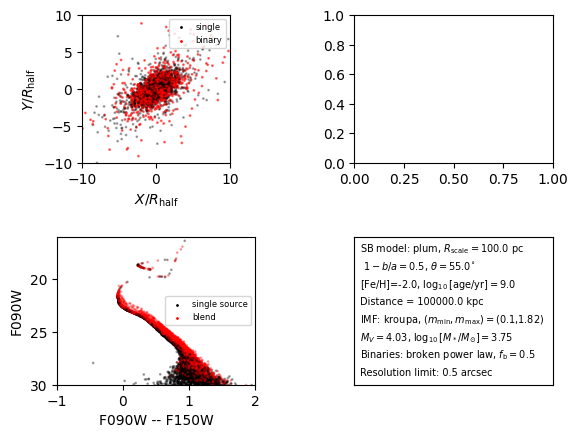

In [22]:
### Repeat using the broken power law separation function

#interpolate isochrone at each mass
iso=mist_track.generate(r2d_with_binaries_bpl.mass,logage,feh,accurate=True)
#get bolometric correction for all filters in filter_names
iso_bc=bc_grid.interp([iso['Teff'],iso['logg'],iso['feh'],np.zeros(len(iso))],filter_names)
#apply bolometric corrections
iso_filter_mag=(np.array(iso['Mbol'])-iso_bc.T).T

Mbol_sun=4.74 #solar absolute bolometric magnitude
r2d_with_binaries_blend_bpl=xymass.binary_blend(r2d_with_binaries_bpl,iso_filter_mag,Mbol_sun,resolution_limit_physical)

L_V=10.**(-(iso_filter_mag[17]-Mbol_sun)/2.5) #solar V-band luminosity
M_V=Mbol_sun-2.5*np.log10(np.sum(L_V)) #V-band luminosity of sample population
mass_tot=np.sum(r2d_with_binaries_bpl.mass) #total mass of sampled population

f090w=r2d_with_binaries_blend_bpl.mag.T[18]+dmodulus #apparent magnitude of sampled stars in JWST F090W
f150w=r2d_with_binaries_blend_bpl.mag.T[19]+dmodulus #apparent magnitude of sampled stars in JWST F150W

#simulate observational errors similar to JWST ERS program (Weisz et al. 2022)
e_f090w=10.**(0.3*f090w-9.7)
e_f150w=10.**(0.3*f150w-9.35)

f090w_obs=f090w+np.random.normal(loc=0.,scale=e_f090w)
f150w_obs=f150w+np.random.normal(loc=0.,scale=e_f150w)

mag=f090w_obs #simulated F090W magnitudes, including observational errors
col=f090w_obs-f150w_obs #simulated F090W - F150W colors, including observational errors

fig=plt.figure(1)
ax1=fig.add_subplot(221)
ax2=fig.add_subplot(222)
ax3=fig.add_subplot(223)
ax4=fig.add_subplot(224)
fig.subplots_adjust(wspace=0.5,hspace=0.5)

cols=np.full(len(r2d_with_binaries_bpl.item),'k')
cols[r2d_with_binaries_bpl.item>0]='r'
ax1.scatter([-999],[-999],color='k',label='single',s=1)
ax1.scatter([-999],[-999],color='r',label='binary',s=1)
ax1.scatter(r2d_with_binaries_bpl.r_xyz.T[0]/r2d.rhalf_2d.value,r2d_with_binaries_bpl.r_xyz.T[1]/r2d.rhalf_2d.value,color=cols,s=1,alpha=0.3)
ax1.set_xlabel(r'$X / R_{\rm half}$')
ax1.set_ylabel(r'$Y / R_{\rm half}$')
ax1.legend(loc=1,fontsize=6)
ax1.set_xlim([-10,10])
ax1.set_ylim([-10,10])
ax1.set_aspect('equal')

cols=np.full(len(col),'k',dtype='str')
cols[r2d_with_binaries_blend_bpl.blend]='r'
ax3.scatter([-999],[-999],color='k',label='single source',s=1)
ax3.scatter([-999],[-999],color='r',label='blend',s=1)
ax3.scatter(col,mag,color=cols,alpha=0.3,s=1)
ax3.set_xlabel('F090W -- F150W')
ax3.set_ylabel('F090W')
ax3.set_ylim([30,16])
ax3.set_xlim([-1,2])
ax3.legend(fontsize=6)

ax4.set_xlim([0,1])
ax4.set_ylim([0,1])
ax4.text(0.03,0.9,'SB model: '+sb_model+r', $R_{\rm scale}=$'+str(round(r_scale.value,0))+' '+str(r_scale.unit),fontsize=7)
ax4.text(0.03,0.78,r' $1-b/a = $'+str(round(ellipticity,2,))+r', $\theta=$'+str(round(position_angle,2))+r'$^{\circ}$',fontsize=7)
ax4.text(0.03,0.66,'[Fe/H]='+str(feh)+r', $\log_{10}[\mathrm{age/yr}]=$'+str(round(logage,2)),fontsize=7)
ax4.text(0.03,0.54,'Distance = '+str(round(distance.to(u.kpc).value,0))+' kpc',fontsize=7)
ax4.text(0.03,0.42,'IMF: '+imf_model+', '+r'$(m_{\rm min},m_{\rm max})=($'+str(round(imf_m_min,2))+','+str(round(m_max,2))+'$)$',fontsize=7)
ax4.text(0.03,0.30,r'$M_V=$'+str(round(M_V,2))+', '+r'$\log_{10}[M_*/M_{\odot}]=$'+str(round(np.log10(mass_tot),2)),fontsize=7)
ax4.text(0.03,0.18,'Binaries: broken power law, '+r'$f_{\rm b}=$'+str(round(f_binary,2)),fontsize=7)
ax4.text(0.03,0.06,'Resolution limit: '+str(round(resolution_limit.value,2))+' arcsec',fontsize=7)
ax4.tick_params(left=False,top=False,bottom=False,right=False,labelleft=False,labeltop=False,labelbottom=False,labelright=False)
plt.show()
